In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv("/content/Walmart Sales Forecast.csv")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [16]:
df.isnull().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0


In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['IsHoliday'] = le.fit_transform(df['IsHoliday'])
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,0
1,1,1,2010-02-12,46039.49,1
2,1,1,2010-02-19,41595.55,0
3,1,1,2010-02-26,19403.54,0
4,1,1,2010-03-05,21827.90,0


In [18]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Feature engineering: extract useful time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,Day
0,1,1,2010-02-05,24924.50,0,2010,2,5,5
1,1,1,2010-02-12,46039.49,1,2010,2,6,12
2,1,1,2010-02-19,41595.55,0,2010,2,7,19
3,1,1,2010-02-26,19403.54,0,2010,2,8,26
4,1,1,2010-03-05,21827.90,0,2010,3,9,5


In [19]:
from sklearn.model_selection import train_test_split
X = df.drop(['Date', 'Weekly_Sales'], axis=1)
y = df['Weekly_Sales']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

RMSE: 22482.3683482147
R2 Score: 0.03070948634089632


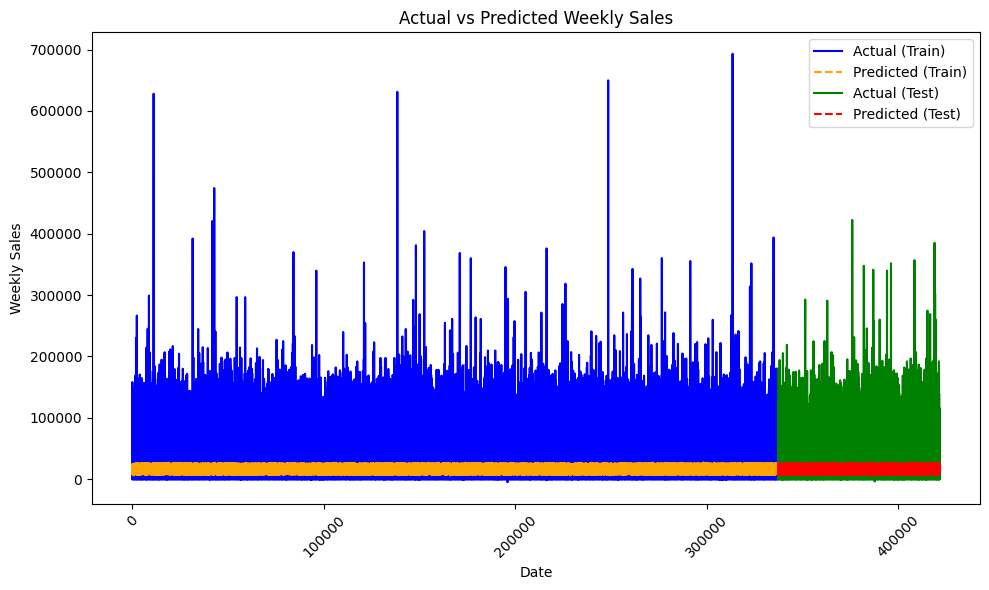

In [25]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df.index[:len(y_train)], y_train, label='Actual (Train)', color='blue')
plt.plot(df.index[:len(y_train)], model.predict(X_train), label='Predicted (Train)', color='orange', linestyle='--') # Use model.predict(X_train) for training predictions
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], y_test, label='Actual (Test)', color='green')
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], y_pred, label='Predicted (Test)', color='red', linestyle='--') # Changed y_test_pred to y_pred
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
model2 = RandomForestRegressor(n_estimators=200, random_state=42)
model2.fit(X_train, y_train)

# Predictions
y_pred2 = model2.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred2)))
print("R2 Score:", r2_score(y_test, y_pred2))

RMSE: 3786.7611084798896
R2 Score: 0.9725017117183021


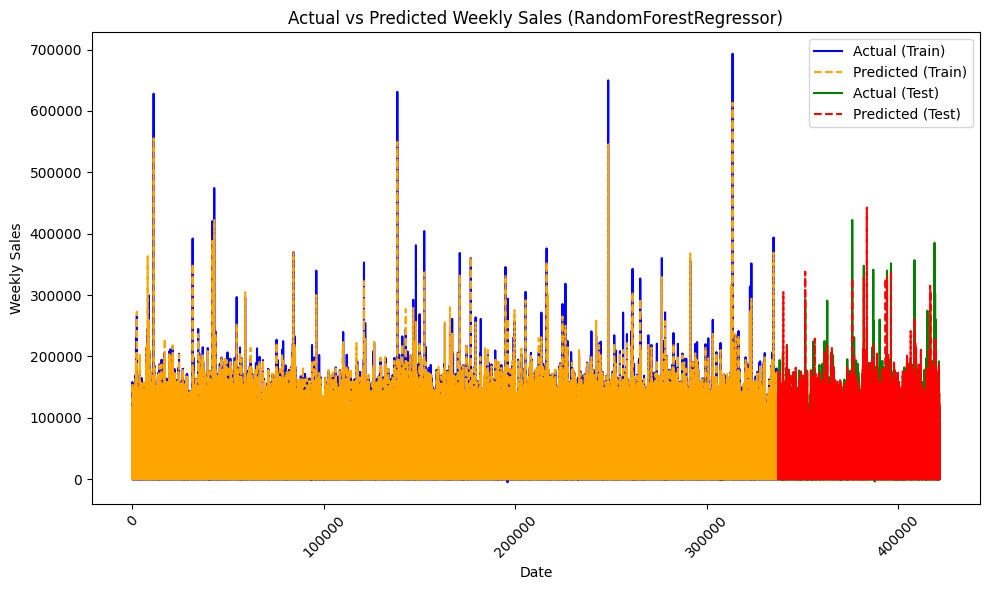

In [36]:
# Plot actual vs predicted values for RandomForestRegressor
plt.figure(figsize=(10, 6))
plt.plot(df.index[:len(y_train)], y_train, label='Actual (Train)', color='blue')
plt.plot(df.index[:len(y_train)], model2.predict(X_train), label='Predicted (Train)', color='orange', linestyle='--') # Use model2.predict(X_train) for training predictions
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], y_test, label='Actual (Test)', color='green')
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], y_pred2, label='Predicted (Test)', color='red', linestyle='--') # Use y_pred2 for RandomForestRegressor test predictions
plt.title('Actual vs Predicted Weekly Sales (RandomForestRegressor)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit  # If sklearn available

# Model
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.5)

# Time-aware CV (e.g., 3 folds)
tscv = TimeSeriesSplit(n_splits=3)
for train_idx, val_idx in tscv.split(X_train):
    reg.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    # Validate on val_idx...

# Fit on full train and predict
reg.fit(X_train, y_train)
preds = reg.predict(X_test)

print("R2 Score:", r2_score(y_test, preds))
print('RMSE:', np.sqrt(np.mean((preds - y_test)**2)))

R2 Score: 0.9529279510345972
RMSE: 4954.463453370013


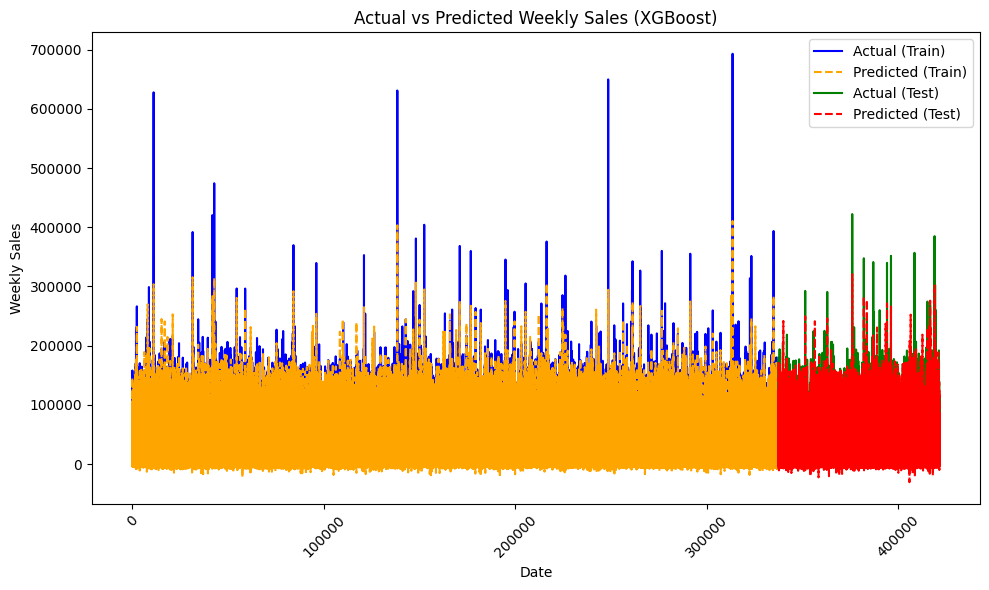

In [35]:
# Plot actual vs predicted values for XGBoost
plt.figure(figsize=(10, 6))
plt.plot(df.index[:len(y_train)], y_train, label='Actual (Train)', color='blue')
plt.plot(df.index[:len(y_train)], reg.predict(X_train), label='Predicted (Train)', color='orange', linestyle='--') # Use reg.predict(X_train) for training predictions
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], y_test, label='Actual (Test)', color='green')
plt.plot(df.index[len(y_train):len(y_train)+len(y_test)], preds, label='Predicted (Test)', color='red', linestyle='--') # Use preds for XGBoost test predictions
plt.title('Actual vs Predicted Weekly Sales (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

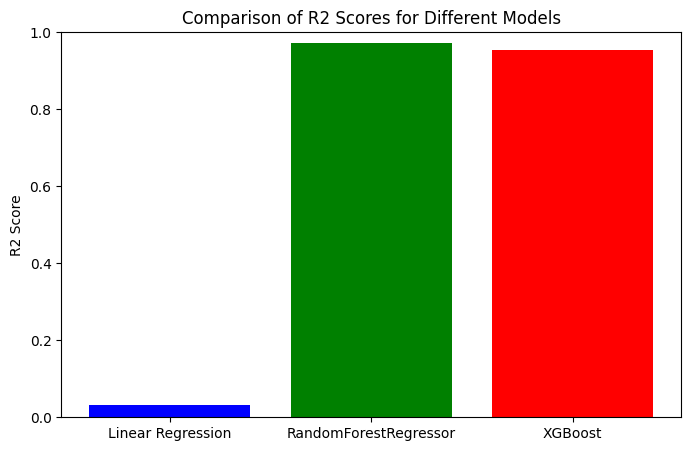

In [37]:
r2_scores = {
    'Linear Regression': r2_score(y_test, y_pred),
    'RandomForestRegressor': r2_score(y_test, y_pred2),
    'XGBoost': r2_score(y_test, preds)
}

plt.figure(figsize=(8, 5))
plt.bar(r2_scores.keys(), r2_scores.values(), color=['blue', 'green', 'red'])
plt.ylabel('R2 Score')
plt.title('Comparison of R2 Scores for Different Models')
plt.ylim(0, 1) # R2 score is between 0 and 1
plt.show()